In [22]:
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

print("Digits NN")

ModuleNotFoundError: No module named 'openpyxl'

# Dataset

In [2]:
# Dataset

# Each row has an image!
# There are 2000 images, 200 for each digit.
datasetDigits = np.loadtxt('mfeat-pix.txt')

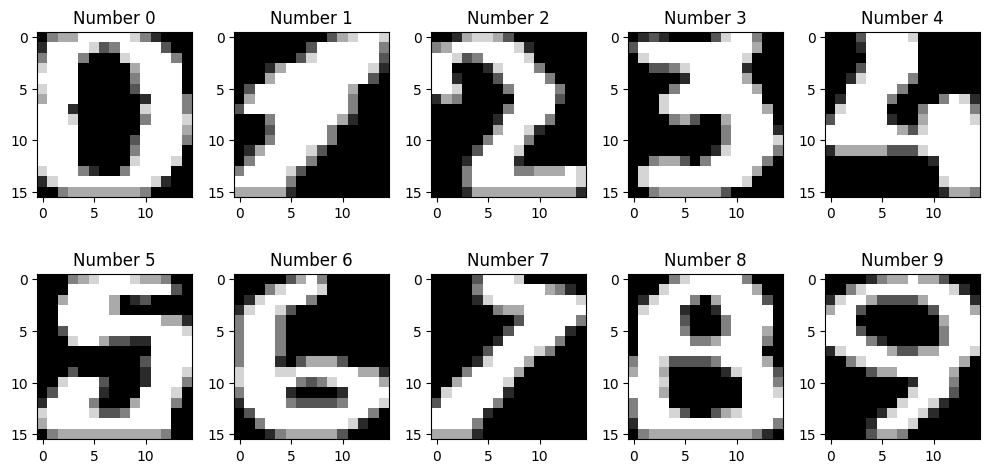

In [3]:
# Visualize the data!
def get_digit_image(data, digit):
    #Gets the first image of the digit
    return datasetDigits[digit * 200].reshape(16, 15) # 16x15 -> height vs width

plt.figure(figsize=(10, 5))
for digit in range(10):
    plt.subplot(2, 5, digit + 1)
    image = get_digit_image(datasetDigits, digit)
    plt.imshow(image, cmap='gray',vmin=0, vmax=6) # images in grayscale from 1 to 6
    plt.title(f'Number {digit}')

plt.tight_layout()
plt.show()

# Pre-processing

In [4]:
# Creating the labels
dataLabels = np.array([i // 200 for i in range(datasetDigits.shape[0])])

In [5]:
# Normalize the data
scaler = MinMaxScaler()
dataPreProcessed = scaler.fit_transform(datasetDigits)
dataPreProcessed

array([[0.        , 0.5       , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16666667, ..., 0.5       , 0.25      ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16666667, ..., 0.        , 0.        ,
        0.        ]])

# Training

Our MLP gen1 (2 layers, 240 neurons) network was chosen following basic tests:
->Training Accuracy: 100.00%
->Test Accuracy: 97.55%
Running a search for the best architecture, gen2 (8 layers, 260 neurons) came to life:
->Training Accuracy: 99.98%
->Test Accuracy: 97.85%

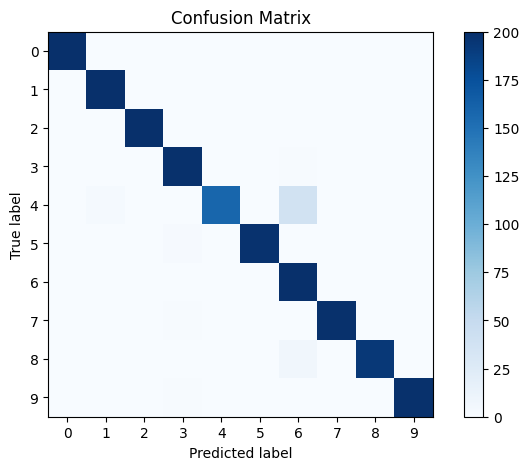

In [31]:
# Initialize the neural network regressor [multilayer perceptron (MLP)]
mlp = MLPClassifier(hidden_layer_sizes=(260,260,260,260,260,260,260,260), # Layers and Neurons (240,240) -> best performance
                   activation='relu', # Activation function
                   solver='adam', # Optimization algorithm
                   max_iter=1000, # Max number of iterations
                   random_state=42,
                   warm_start=True,
                   verbose=False)

# Fit the model to the training data
mlp.fit(dataPreProcessed, dataLabels)

# Making predictions on the test set
predicted = mlp.predict(dataPreProcessed)

# Display confusion matrix (Training Set)
conf_matrix = confusion_matrix(dataLabels, predicted)
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Mean Training Accuracy: 99.98%
Mean Test Accuracy: 97.85%
Mean Training F1 Score: 99.98%
Mean Test F1 Score: 97.85%


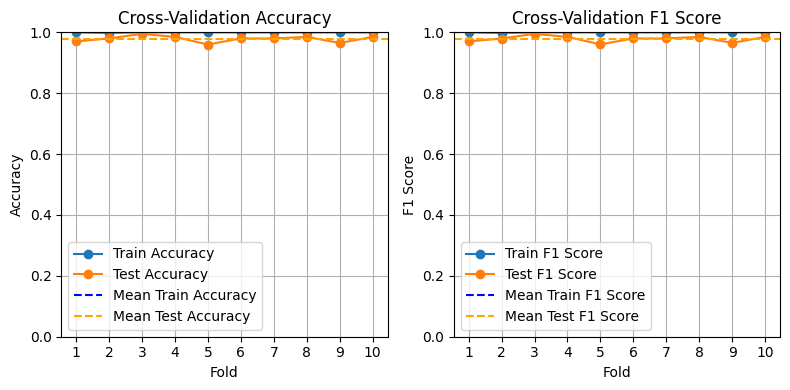

In [32]:
# Evaluate the performance
cv_results = cross_validate(mlp, dataPreProcessed, dataLabels, cv=10, n_jobs=-1, return_train_score=True, scoring=['accuracy', 'f1_macro'])  # 10-fold cross-validation

mean_train_accuracy = np.mean(cv_results['train_accuracy']) * 100
mean_test_accuracy = np.mean(cv_results['test_accuracy']) * 100
mean_train_f1 = np.mean(cv_results['train_f1_macro']) * 100
mean_test_f1 = np.mean(cv_results['test_f1_macro']) * 100

print(f"Mean Training Accuracy: {mean_train_accuracy:.2f}%")
print(f"Mean Test Accuracy: {mean_test_accuracy:.2f}%")
print(f"Mean Training F1 Score: {mean_train_f1:.2f}%")
print(f"Mean Test F1 Score: {mean_test_f1:.2f}%")

# Visual Results:
plt.figure(figsize=(8, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(cv_results['train_accuracy'], label='Train Accuracy', marker='o')
plt.plot(cv_results['test_accuracy'], label='Test Accuracy', marker='o')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(ticks=np.arange(10), labels=np.arange(1, 11))
plt.ylim(0, 1)
plt.axhline(mean_train_accuracy / 100, color='blue', linestyle='--', label='Mean Train Accuracy')
plt.axhline(mean_test_accuracy / 100, color='orange', linestyle='--', label='Mean Test Accuracy')
plt.legend()
plt.grid()

# F1 Score
plt.subplot(1, 2, 2)
plt.plot(cv_results['train_f1_macro'], label='Train F1 Score', marker='o')
plt.plot(cv_results['test_f1_macro'], label='Test F1 Score', marker='o')
plt.title('Cross-Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.xticks(ticks=np.arange(10), labels=np.arange(1, 11))
plt.ylim(0, 1)
plt.axhline(mean_train_f1 / 100, color='blue', linestyle='--', label='Mean Train F1 Score')
plt.axhline(mean_test_f1 / 100, color='orange', linestyle='--', label='Mean Test F1 Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Regularization

### Model Structure

In [21]:
# Define the model structure!
# Test different combinations of layers and number of neurons

results = []

def train_and_evaluate(nLayers, nNeurons, dataPreProcessed, dataLabels):
    layers = [nNeurons] * nLayers

    mlpI = MLPClassifier(
        hidden_layer_sizes=layers,
        early_stopping=False,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        max_iter=1000,
        random_state=42,
        warm_start=True,
        verbose=False
    )

    mlpI_results = cross_validate(mlpI, dataPreProcessed, dataLabels, cv=10, n_jobs=-1, return_train_score=True, scoring=['accuracy'])

    mean_train_accuracyI = np.mean(mlpI_results['train_accuracy']) * 100
    mean_test_accuracyI = np.mean(mlpI_results['test_accuracy']) * 100

    print(f"nLayers: {nLayers}, nNeurons: {nNeurons}")
    print(f"Mean Training Accuracy: {mean_train_accuracyI:.2f}%")
    print(f"Mean Test Accuracy: {mean_test_accuracyI:.2f}%")

    return {
        'nLayers': nLayers,
        'nNeurons': nNeurons,
        'Mean Train Accuracy': mean_train_accuracyI,
        'Mean Test Accuracy': mean_test_accuracyI
    }

results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(nLayers, nNeurons, dataPreProcessed, dataLabels)
    for nLayers in range(1, 21)
    for nNeurons in range(120, 361, 10)
    )

resultsPandas = pd.DataFrame(results)

nLayers: 1, nNeurons: 120
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.15%
nLayers: 1, nNeurons: 130
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.55%
nLayers: 1, nNeurons: 160
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.40%
nLayers: 1, nNeurons: 140
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.50%
nLayers: 1, nNeurons: 150
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.30%
nLayers: 1, nNeurons: 200
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.25%
nLayers: 1, nNeurons: 170
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.10%
nLayers: 1, nNeurons: 180
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.50%
nLayers: 1, nNeurons: 220
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.10%
nLayers: 1, nNeurons: 210
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.35%
nLayers: 1, nNeurons: 190
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.45%
nLayers: 1, nNeurons: 230
Mean Training Accuracy: 100.00%
Mean Te

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


nLayers: 6, nNeurons: 170
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.05%
nLayers: 5, nNeurons: 360
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.50%
nLayers: 6, nNeurons: 180
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 96.95%
nLayers: 6, nNeurons: 190
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.60%
nLayers: 6, nNeurons: 200
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.35%
nLayers: 6, nNeurons: 210
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.40%
nLayers: 6, nNeurons: 220
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.35%
nLayers: 6, nNeurons: 230
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.40%
nLayers: 6, nNeurons: 240
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.45%
nLayers: 6, nNeurons: 250
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.60%
nLayers: 6, nNeurons: 260
Mean Training Accuracy: 100.00%
Mean Test Accuracy: 97.75%
nLayers: 6, nNeurons: 270
Mean Training Accuracy: 100.00%
Mean Te

ModuleNotFoundError: No module named 'openpyxl'

In [26]:
# Transform the results into an excel sheet
resultsPandas.to_excel('architecture_results.xlsx', index=False)
resultsPandas

,nLayers,nNeurons,Mean Train Accuracy,Mean Test Accuracy
0,1,120,100.000000,97.15
1,1,130,100.000000,97.55
2,1,140,100.000000,97.50
3,1,150,100.000000,97.30
4,1,160,100.000000,97.40
...,...,...,...,...
495,20,320,93.161111,89.70
496,20,330,94.616667,91.45
497,20,340,90.838889,86.95
498,20,350,91.450000,88.40


# New Data Test

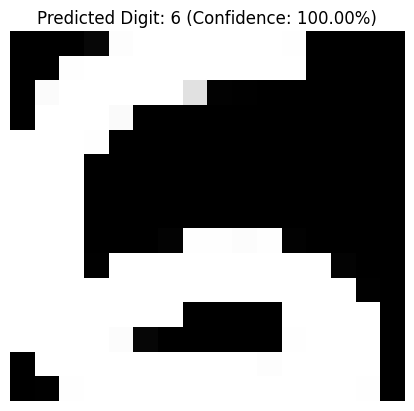

The predicted digit is: 6 with 100.00% confidence


In [16]:
def classify_digit(image_path, model, scaler):

    # Read image file
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resizes
    image_resized = cv2.resize(image, (16, 15))

    # Reshape to 1D array
    image_1D = image_resized.flatten().reshape(1, -1)

    # Normalize
    image_1D_normalized = scaler.transform(image_1D)

    # Prediction
    probabilities = model.predict_proba(image_1D_normalized)
    predicted_digit = np.argmax(probabilities)
    confidence = np.max(probabilities)

    # Display input image
    plt.imshow(image_resized, cmap='gray')
    plt.title(f'Predicted Digit: {predicted_digit} (Confidence: {confidence * 100:.2f}%)')
    plt.axis('off')
    plt.show()

    return predicted_digit, confidence

image_path = 'new_images/5.jpg'
predicted_digit, confidence = classify_digit(image_path, mlp, scaler)
print(f"The predicted digit is: {predicted_digit} with {confidence * 100:.2f}% confidence")